In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/readme.txt
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/license.txt
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/ground_truth/hole/000_mask.png
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/ground_truth/hole/003_mask.png
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/ground_truth/hole/004_mask.png
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/ground_truth/hole/005_mask.png
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/ground_truth/hole/001_mask.png
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/ground_truth/hole/006_mask.png
/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/wood/ground_truth/hole/008_mask.png
/kaggle/input/industrial-defect

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from PIL import Image
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

# Model 1: Grid defect segmentation


In [5]:
# Define the paths to the folders
grid_base_dir = "/kaggle/input/industrial-defect-segmentation/Industrial defect segmentation/grid"
grid_train_dir = os.path.join(grid_base_dir, "train")
grid_test_dir = os.path.join(grid_base_dir, "test")
grid_gt_dir = os.path.join(grid_base_dir, "ground_truth")

# Initialize lists to store data for DataFrame
grid_data = []

# Handle "good" folder
# Gather images from "train" folder
grid_train_good_dir = os.path.join(grid_train_dir, "good")
if os.path.exists(grid_train_good_dir):
    grid_train_good_images = os.listdir(grid_train_good_dir)
    for img_name in grid_train_good_images:
        img_path = os.path.join(grid_train_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in train
        category = "good"
        mask = 0
        grid_data.append([img_path, mask_path, category, mask])

# Gather images from "test/good" folder
grid_test_good_dir = os.path.join(grid_test_dir, "good")
if os.path.exists(grid_test_good_dir):
    grid_test_good_images = os.listdir(grid_test_good_dir)
    for img_name in grid_test_good_images:
        img_path = os.path.join(grid_test_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in test
        category = "good"
        mask = 0
        grid_data.append([img_path, mask_path, category, mask])
# Handle ground truth folders
grid_gt_categories = ["bent", "broken", "glue", "metal_contaminatic", "thread"]
for category in grid_gt_categories:
    grid_test_category_dir = os.path.join(grid_test_dir, category)
    grid_gt_category_dir = os.path.join(grid_gt_dir, category)
    if os.path.exists(grid_test_category_dir) and os.path.exists(grid_gt_category_dir):
        grid_test_images = os.listdir(grid_test_category_dir)
        for img_name in grid_test_images:
            img_path = os.path.join(grid_test_category_dir, img_name)
            mask_name = img_name.split('.')[0] + "_mask.png"
            mask_path = os.path.join(grid_gt_category_dir, mask_name)
            mask_category = category
            mask = 1
            grid_data.append([img_path, mask_path, mask_category, mask])


# Create a DataFrame
grid_df = pd.DataFrame(grid_data, columns=["image_path", "mask_path", "categories", "mask"])

# Display the DataFrame
print(grid_df)


                                            image_path  \
0    /kaggle/input/industrial-defect-segmentation/I...   
1    /kaggle/input/industrial-defect-segmentation/I...   
2    /kaggle/input/industrial-defect-segmentation/I...   
3    /kaggle/input/industrial-defect-segmentation/I...   
4    /kaggle/input/industrial-defect-segmentation/I...   
..                                                 ...   
326  /kaggle/input/industrial-defect-segmentation/I...   
327  /kaggle/input/industrial-defect-segmentation/I...   
328  /kaggle/input/industrial-defect-segmentation/I...   
329  /kaggle/input/industrial-defect-segmentation/I...   
330  /kaggle/input/industrial-defect-segmentation/I...   

                                             mask_path categories  mask  
0                                                            good     0  
1                                                            good     0  
2                                                            good     0  
3      

In [6]:
# Define image dimensions
width, height = 1024, 1024

# Create a solid black image using NumPy
black_image_array = np.zeros((height, width, 3), dtype=np.uint8)
black_image = Image.fromarray(black_image_array)

In [7]:
grid_df = pd.DataFrame(grid_data, columns=["image_path", "mask_path", "categories", "mask"])

# Fill the blank values in 'mask_path' column with the black image
for index, row in grid_df.iterrows():
    if pd.isnull(row['mask_path']) or row['mask_path'] == '':
        black_image_path = f'black_image_{index}.png'  # Unique path for each image
        black_image.save(black_image_path)
        grid_df.at[index, 'mask_path'] = black_image_path

print("DataFrame after filling blank values in 'mask_path' column:")
print(grid_df)

DataFrame after filling blank values in 'mask_path' column:
                                            image_path  \
0    /kaggle/input/industrial-defect-segmentation/I...   
1    /kaggle/input/industrial-defect-segmentation/I...   
2    /kaggle/input/industrial-defect-segmentation/I...   
3    /kaggle/input/industrial-defect-segmentation/I...   
4    /kaggle/input/industrial-defect-segmentation/I...   
..                                                 ...   
326  /kaggle/input/industrial-defect-segmentation/I...   
327  /kaggle/input/industrial-defect-segmentation/I...   
328  /kaggle/input/industrial-defect-segmentation/I...   
329  /kaggle/input/industrial-defect-segmentation/I...   
330  /kaggle/input/industrial-defect-segmentation/I...   

                                             mask_path categories  mask  
0                                    black_image_0.png       good     0  
1                                    black_image_1.png       good     0  
2                    

In [8]:
grid_df.head()

image_path          mask_path  \
0  /kaggle/input/industrial-defect-segmentation/I...  black_image_0.png   
1  /kaggle/input/industrial-defect-segmentation/I...  black_image_1.png   
2  /kaggle/input/industrial-defect-segmentation/I...  black_image_2.png   
3  /kaggle/input/industrial-defect-segmentation/I...  black_image_3.png   
4  /kaggle/input/industrial-defect-segmentation/I...  black_image_4.png   

  categories  mask  
0       good     0  
1       good     0  
2       good     0  
3       good     0  
4       good     0

In [9]:
grid_df.shape

(331, 4)

In [10]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  331 non-null    object
 1   mask_path   331 non-null    object
 2   categories  331 non-null    object
 3   mask        331 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.5+ KB


### Data augmentation (Grid data)

In [11]:
# Get the dataframe containing grid defected which have masks associated with them.
grid_df_mask = grid_df[grid_df['mask']==1]
grid_df_mask.shape

(46, 4)

In [23]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

# Define the augmentation transformations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    ToTensorV2(),
])

# Create directories to save augmented images and masks
grid_output_image_dir = '/kaggle/working//grid/aug/image/'
grid_output_mask_dir = '/kaggle/working/grid/aug/mask/'
os.makedirs(grid_output_image_dir, exist_ok=True)
os.makedirs(grid_output_mask_dir, exist_ok=True)

# Initialize a list to store augmented data
grid_augmented_data = []

# Loop through each row in wood_df_mask
for index, row in grid_df_mask.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']
    category = row['categories']

    # Set 'mask' column to 1
    grid_df_mask.at[index, 'mask'] = 1

    # Load the image and mask
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))

    # Apply augmentations to both image and mask
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    # Convert PyTorch tensor to NumPy array
    augmented_image = augmented_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC

    # Ensure pixel values are in the range [0, 1] (undo normalization)
    augmented_image = augmented_image.astype(np.float32) / 255.0

    augmented_mask = augmented_mask.squeeze().cpu().numpy()  # Squeeze channel dimension
    augmented_mask[augmented_mask != 0] = 1  # Set all non-zero values to 1
    augmented_mask = (augmented_mask * 255).astype(np.uint8)

    # Save augmented images and masks
    image_filename = f'{category}_{index}_aug.png'
    mask_filename = f'{category}_{index}_aug_mask.png'
    grid_augmented_image_path = os.path.join(grid_output_image_dir, image_filename)
    grid_augmented_mask_path = os.path.join(grid_output_mask_dir, mask_filename)
    
    Image.fromarray(augmented_image * 255).astype(np.uint8)).save(grid_augmented_image_path)  # Convert back to uint8
    Image.fromarray(augmented_mask).save(grid_augmented_mask_path)

    # Append augmented data to the list
    grid_augmented_data.append([grid_augmented_image_path, grid_augmented_mask_path, category, 1])

In [24]:
# Create a DataFrame for augmented data
grid_augmented_df = pd.DataFrame(grid_augmented_data, columns=["image_path", "mask_path", "categories", "mask"])

# Concatenate the original DataFrame 'df' with the augmented DataFrame
grid_concatenated_df = pd.concat([grid_df, grid_augmented_df], ignore_index=True)

# Display the concatenated DataFrame
grid_concatenated_df.tail(50)

image_path  \
327  /kaggle/input/industrial-defect-segmentation/I...   
328  /kaggle/input/industrial-defect-segmentation/I...   
329  /kaggle/input/industrial-defect-segmentation/I...   
330  /kaggle/input/industrial-defect-segmentation/I...   
331   /kaggle/working//grid/aug/image/bent_285_aug.png   
332   /kaggle/working//grid/aug/image/bent_286_aug.png   
333   /kaggle/working//grid/aug/image/bent_287_aug.png   
334   /kaggle/working//grid/aug/image/bent_288_aug.png   
335   /kaggle/working//grid/aug/image/bent_289_aug.png   
336   /kaggle/working//grid/aug/image/bent_290_aug.png   
337   /kaggle/working//grid/aug/image/bent_291_aug.png   
338   /kaggle/working//grid/aug/image/bent_292_aug.png   
339   /kaggle/working//grid/aug/image/bent_293_aug.png   
340   /kaggle/working//grid/aug/image/bent_294_aug.png   
341   /kaggle/working//grid/aug/image/bent_295_aug.png   
342   /kaggle/working//grid/aug/image/bent_296_aug.png   
343  /kaggle/working//grid/aug/image/broken_297_aug...   
344  /kaggle/working//grid/aug/image/broken_298_aug...   
345  /kaggle/working//grid/aug/image/broken_299_aug...   
346  /kaggle/working//grid/aug/image/broken_300_aug...   
347  /kaggle/working//grid/aug/image/broken_301_aug...   
348  /kaggle/working//grid/aug/image/broken_302_aug...   
349  /kaggle/working//grid/aug/image/broken_303_aug...   
350  /kaggle/working//grid/aug/image/broken_304_aug...   
351  /kaggle/working//grid/aug/image/broken_305_aug...   
352  /kaggle/working//grid/aug/image/broken_306_aug...   
353  /kaggle/working//grid/aug/image/broken_307_aug...   
354  /kaggle/working//grid/aug/image/broken_308_aug...   
355   /kaggle/working//grid/aug/image/glue_309_aug.png   
356   /kaggle/working//grid/aug/image/glue_310_aug.png   
357   /kaggle/working//grid/aug/image/glue_311_aug.png   
358   /kaggle/working//grid/aug/image/glue_312_aug.png   
359   /kaggle/working//grid/aug/image/glue_313_aug.png   
360   /kaggle/working//grid/aug/image/glue_314_aug.png   
361   /kaggle/working//grid/aug/image/glue_315_aug.png   
362   /kaggle/working//grid/aug/image/glue_316_aug.png   
363   /kaggle/working//grid/aug/image/glue_317_aug.png   
364   /kaggle/working//grid/aug/image/glue_318_aug.png   
365   /kaggle/working//grid/aug/image/glue_319_aug.png   
366  /kaggle/working//grid/aug/image/thread_320_aug...   
367  /kaggle/working//grid/aug/image/thread_321_aug...   
368  /kaggle/working//grid/aug/image/thread_322_aug...   
369  /kaggle/working//grid/aug/image/thread_323_aug...   
370  /kaggle/working//grid/aug/image/thread_324_aug...   
371  /kaggle/working//grid/aug/image/thread_325_aug...   
372  /kaggle/working//grid/aug/image/thread_326_aug...   
373  /kaggle/working//grid/aug/image/thread_327_aug...   
374  /kaggle/working//grid/aug/image/thread_328_aug...   
375  /kaggle/working//grid/aug/image/thread_329_aug...   
376  /kaggle/working//grid/aug/image/thread_330_aug...   

                                             mask_path categories  mask  
327  /kaggle/input/industrial-defect-segmentation/I...     thread     1  
328  /kaggle/input/industrial-defect-segmentation/I...     thread     1  
329  /kaggle/input/industrial-defect-segmentation/I...     thread     1  
330  /kaggle/input/industrial-defect-segmentation/I...     thread     1  
331  /kaggle/working/grid/aug/mask/bent_285_aug_mas...       bent     1  
332  /kaggle/working/grid/aug/mask/bent_286_aug_mas...       bent     1  
333  /kaggle/working/grid/aug/mask/bent_287_aug_mas...       bent     1  
334  /kaggle/working/grid/aug/mask/bent_288_aug_mas...       bent     1  
335  /kaggle/working/grid/aug/mask/bent_289_aug_mas...       bent     1  
336  /kaggle/working/grid/aug/mask/bent_290_aug_mas...       bent     1  
337  /kaggle/working/grid/aug/mask/bent_291_aug_mas...       bent     1  
338  /kaggle/working/grid/aug/mask/bent_292_aug_mas...       bent     1  
339  /kaggle/working/grid/aug/mask/bent_293_aug_mas...       bent     1  
340  /kaggle/working/grid/aug/mask/bent_294_aug_m

In [25]:
grid_concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  377 non-null    object
 1   mask_path   377 non-null    object
 2   categories  377 non-null    object
 3   mask        377 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 11.9+ KB


### Data visualization (Grid defect)

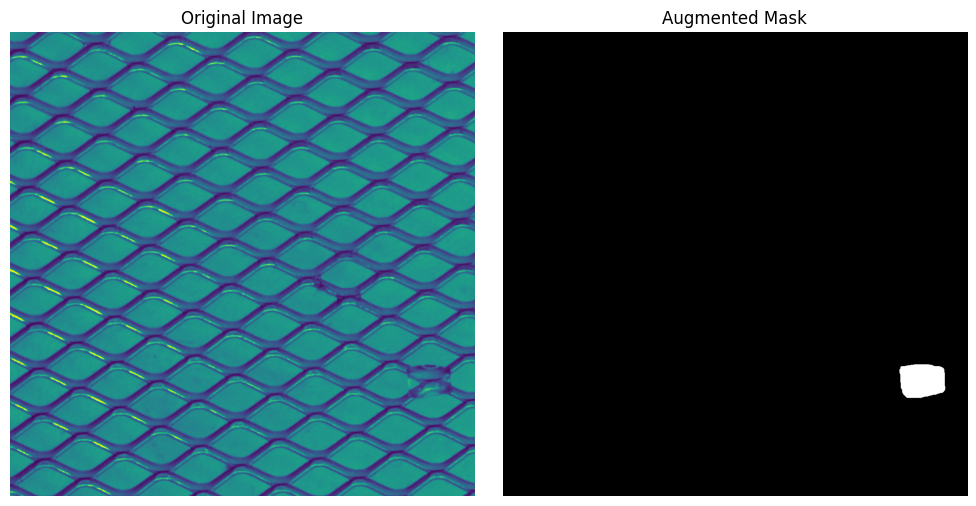

In [26]:
import matplotlib.pyplot as plt

# Define the index you want to visualize
index_to_visualize = 362

# Get the image and mask paths for the selected index
image_path = grid_concatenated_df.loc[index_to_visualize, 'image_path']
mask_path = grid_concatenated_df.loc[index_to_visualize, 'mask_path']

# Load the image and mask using PIL
image = Image.open(image_path)
mask = Image.open(mask_path)

# Create a subplot to display the image and mask side by side
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

# Display the augmented mask
plt.subplot(1, 2, 2)
plt.title('Augmented Mask')
plt.imshow(mask, cmap='gray')  # Use 'gray' colormap for grayscale masks
plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


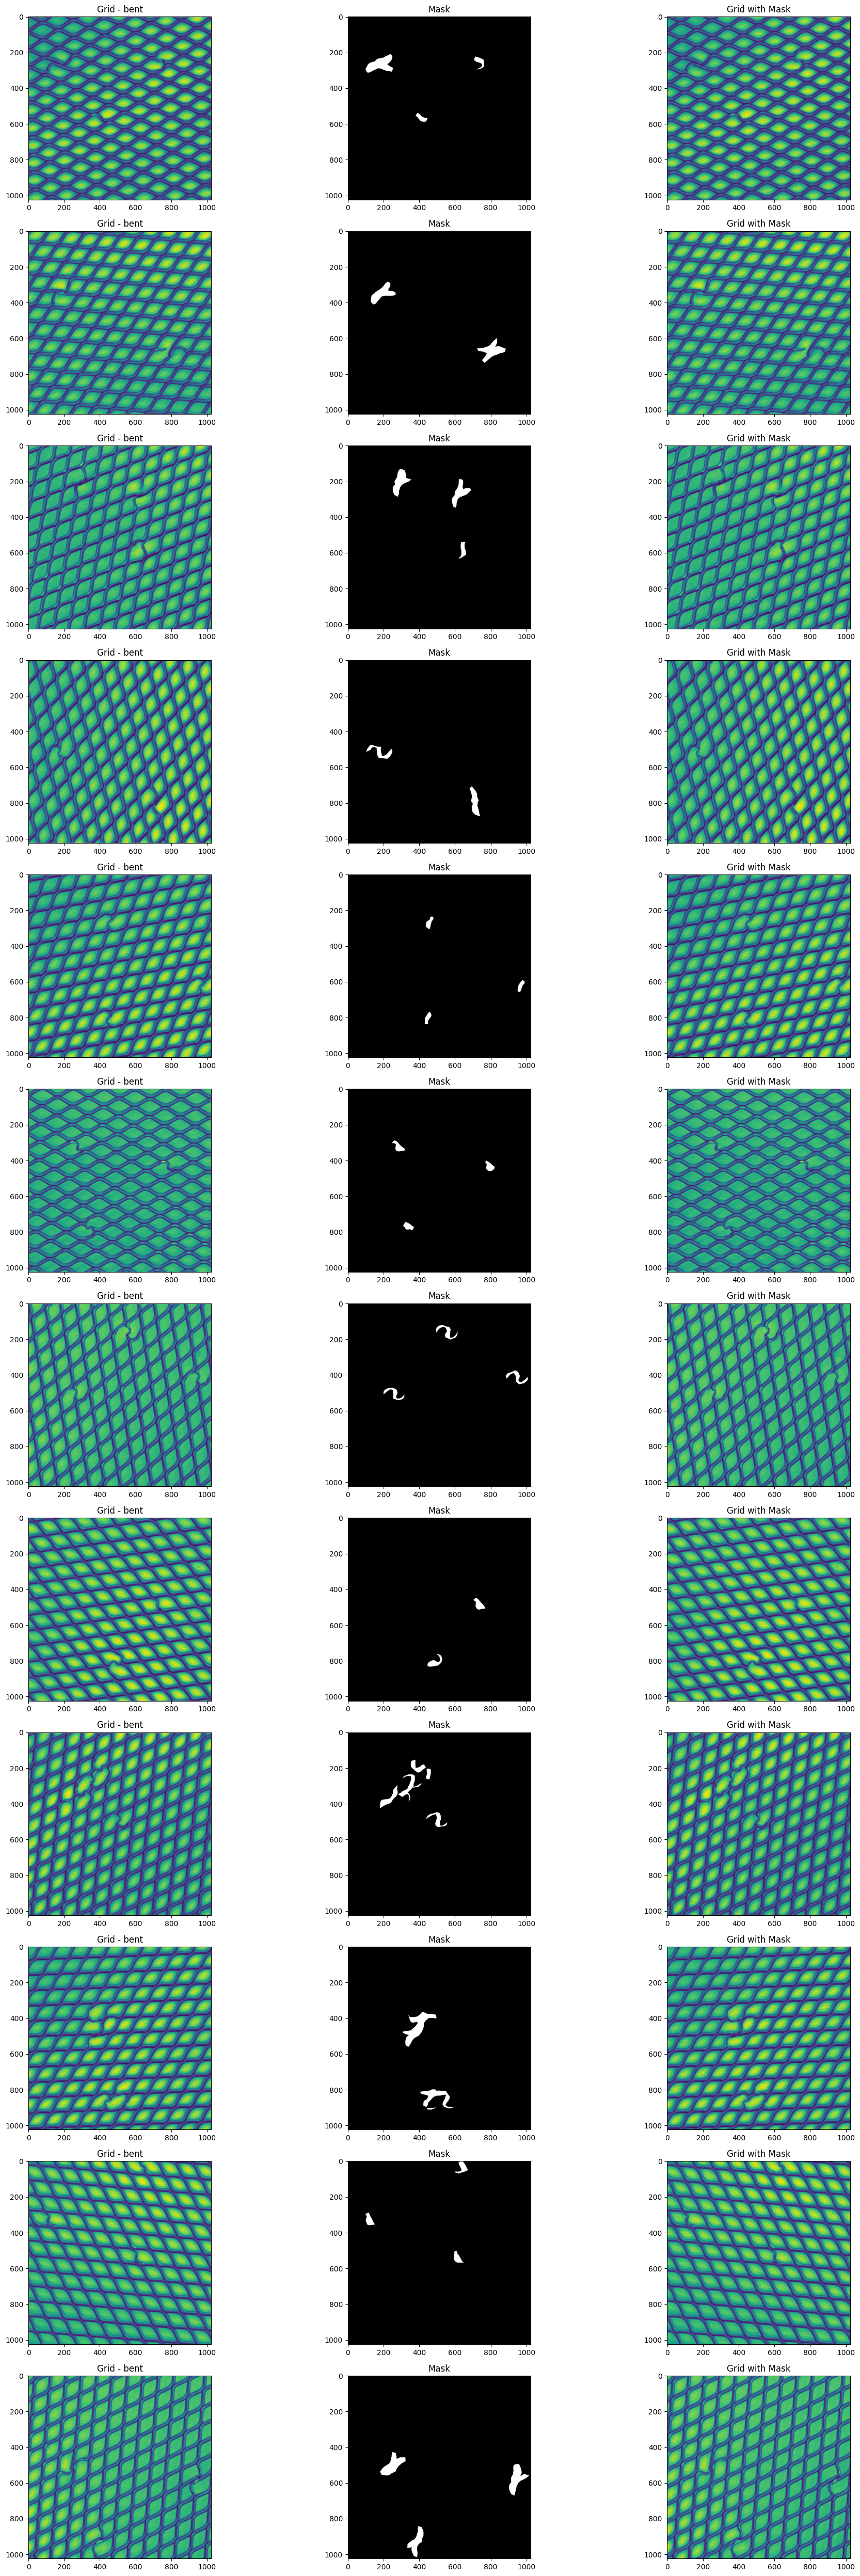

In [28]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(grid_df)):
  if grid_concatenated_df['mask'][i] ==1 and count <12:
    img = io.imread(grid_concatenated_df.image_path[i])
    axs[count][0].title.set_text("Grid - " + str(grid_concatenated_df['categories'][i]))
    axs[count][0].imshow(img)

    mask = io.imread(grid_concatenated_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')


    #img[mask == 255] = (0, 255, 0)
    axs[count][2].title.set_text('Grid with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

### Model training (Grid defect)

In [29]:
grid_df_train = grid_concatenated_df
grid_df_train.shape

(377, 4)

In [31]:
grid_df_train['mask'] = grid_df_train['mask'].apply(lambda x: str(x))

In [33]:
grid_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  377 non-null    object
 1   mask_path   377 non-null    object
 2   categories  377 non-null    object
 3   mask        377 non-null    object
dtypes: object(4)
memory usage: 11.9+ KB


In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(grid_df_train, test_size = 0.2)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes a validation split of 0.2
'''
NOTE: this is to generalize the data to pass to the model
'''
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [37]:
grid_train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


grid_valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
grid_test_datagen=ImageDataGenerator(rescale=1./255.)

grid_test_generator=grid_test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 241 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.


In [38]:
# Load the InceptionV3 model
grid_basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [39]:
grid_basemodel.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [40]:
# freeze the model weights
for layer in grid_basemodel.layers:
  layers.trainable = False

In [41]:
headmodel = grid_basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
output_layer = Dense(2, activation='softmax')(headmodel)
grid_model = Model(inputs=grid_basemodel.input, outputs=output_layer)

In [42]:
grid_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [46]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

# Specify an absolute path for saving the weights
checkpoint_path = '/kaggle/working/grid/classifier-inceptionv3-weights.hdf5.keras'

# Update the ModelCheckpoint callback
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

# Use the updated checkpoint path in the fit function
history = grid_model.fit(grid_train_generator, steps_per_epoch=grid_train_generator.n // 16, epochs=15, validation_data=grid_valid_generator, validation_steps=grid_valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727849610.288912    1052 service.cc:145] XLA service 0x7b3da0004360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727849610.288980    1052 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/15 ━━━━━━━━━━━━━━━━━━━━ 17:20 74s/step - accuracy: 0.7500 - loss: 0.5981

I0000 00:00:1727849646.556572    1052 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6557 - loss: 0.8554   
Epoch 1: val_loss improved from inf to 1.41207, saving model to /kaggle/working/grid/classifier-inceptionv3-weights.hdf5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.6578 - loss: 0.8486 - val_accuracy: 0.8333 - val_loss: 1.4121
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8125 - loss: 0.6096

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.41207
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.8125 - loss: 0.6096 - val_accuracy: 0.5833 - val_loss: 2.7504
Epoch 3/15
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7743 - loss: 0.5727
Epoch 3: val_loss did not improve from 1.41207
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.7709 - loss: 0.5764 - val_accuracy: 0.7708 - val_loss: 4.4181
Epoch 4/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6875 - loss: 0.7112
Epoch 4: val_loss improved from 1.41207 to 0.99488, saving model to /kaggle/working/grid/classifier-inceptionv3-weights.hdf5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.6875 - loss: 0.7112 - val_accuracy: 0.8333 - val_loss: 0.9949
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7564 - loss: 0.5602
Epoch 5: val_loss did not improve from 0.99488
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.7558 - loss: 0.5617 - val_accuracy: 0.7500 - val_loss: 3.0170
E

In [79]:
model_json = grid_model.to_json()
with open("classifier-inceptionv3-model.json","w") as json_file:
  json_file.write(model_json)

#grid_model.save_weights("grid_model.h5")
print("Saved model to disk")

Saved model to disk


### Do model prediction using the best model

In [48]:
grid_test_predict = grid_model.predict(grid_test_generator, steps = grid_test_generator.n // 16, verbose =1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step


In [50]:
# Obtain the predicted class from the model
grid_predict = []

for i in grid_test_predict:
  grid_predict.append(str(np.argmax(i)))

grid_predict = np.asarray(grid_predict)

In [51]:
grid_predict

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
      dtype='<U1')

In [53]:
# since we have used test generator, it limited the images to len(predict), due to batch size
grid_original = np.asarray(test['mask'])[:len(grid_predict)]
len(grid_original)

64

In [54]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(grid_original, grid_predict)
accuracy

0.734375

<Axes: >

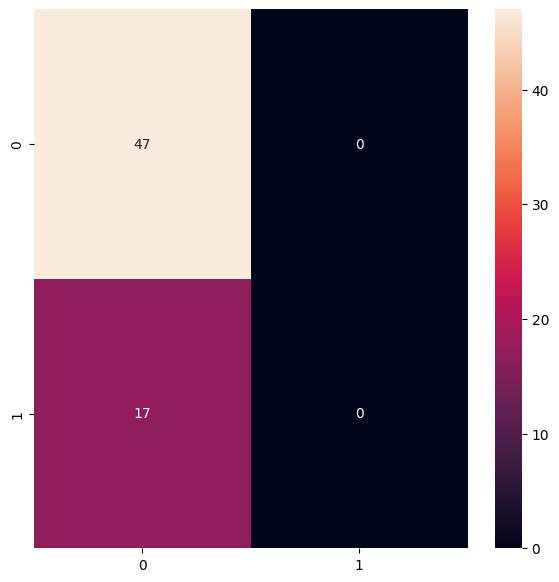

In [55]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(grid_original, grid_predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

## Segmentation model (Grid defect)

In [56]:
grid_concatenated_df['mask'] = grid_concatenated_df['mask'].apply(lambda x: int(x))

In [57]:
# Get the dataframe containing Grid defected which have masks associated with them.
grid_df_mask = grid_concatenated_df[grid_concatenated_df['mask']==1]
grid_df_mask.shape

(92, 4)

In [58]:
grid_df_mask

image_path  \
285  /kaggle/input/industrial-defect-segmentation/I...   
286  /kaggle/input/industrial-defect-segmentation/I...   
287  /kaggle/input/industrial-defect-segmentation/I...   
288  /kaggle/input/industrial-defect-segmentation/I...   
289  /kaggle/input/industrial-defect-segmentation/I...   
..                                                 ...   
372  /kaggle/working//grid/aug/image/thread_326_aug...   
373  /kaggle/working//grid/aug/image/thread_327_aug...   
374  /kaggle/working//grid/aug/image/thread_328_aug...   
375  /kaggle/working//grid/aug/image/thread_329_aug...   
376  /kaggle/working//grid/aug/image/thread_330_aug...   

                                             mask_path categories  mask  
285  /kaggle/input/industrial-defect-segmentation/I...       bent     1  
286  /kaggle/input/industrial-defect-segmentation/I...       bent     1  
287  /kaggle/input/industrial-defect-segmentation/I...       bent     1  
288  /kaggle/input/industrial-defect-segmentation/I...       bent     1  
289  /kaggle/input/industrial-defect-segmentation/I...       bent     1  
..                                                 ...        ...   ...  
372  /kaggle/working/grid/aug/mask/thread_326_aug_m...     thread     1  
373  /kaggle/working/grid/aug/mask/thread_327_aug_m...     thread     1  
374  /kaggle/working/grid/aug/mask/thread_328_aug_m...     thread     1  
375  /kaggle/working/grid/aug/mask/thread_329_aug_m...     thread     1  
376  /kaggle/working/grid/aug/mask/thread_330_aug_m...     thread     1  

[92 rows x 4 columns]

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(grid_df_mask, test_size=0.2)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [64]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [65]:
'''
This custom datagenerator code is adapted from the Python code file "my_classes.py" located at the following GitHub repository:
https://github.com/afshinea/keras-data-generator/blob/master/my_classes.py

'''
#creating a custom datagenerator:

import cv2
import numpy as np
import tensorflow as tf
from skimage import io

# Creating a custom datagenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids, mask, image_dir='./', batch_size=8, img_h=256, img_w=256, shuffle=True):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_ids = [self.ids[i] for i in indexes]
        list_mask = [self.mask[i] for i in indexes]
        X, y = self.__data_generation(list_ids, list_mask)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_ids)):
            img_path = list_ids[i]
            mask_path = list_mask[i]
            img = io.imread(img_path)
            mask = io.imread(mask_path)
            img = cv2.resize(img, (self.img_h, self.img_w))
            img = np.array(img, dtype=np.float64)
            mask = cv2.resize(mask, (self.img_h, self.img_w))
            mask = np.array(mask, dtype=np.float64)

            img -= img.mean()
            img /= img.std()
            mask -= mask.mean()
            mask /= mask.std()

            X[i,] = img
            y[i,] = np.expand_dims(mask, axis=2)

        y = (y > 0).astype(int)

        return X, y

In [66]:
def prediction(test, model, model_seg):
    '''
    Two shots prediction.
    1. Will predict if the model has mask or not
    2. Do image segmentation if the model predict the image has mask

    Args:
      - test: test data
      - model: model to predict the mask
      - model_seg: model to do image segmentation
    '''
    directory = "./"
    mask = []
    image_id = []
    has_mask = []

    for i in test.image_path:
        path = i
        img = io.imread(path)
        img = img * 1.0 / 255.
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)
        img = np.reshape(img, (1, 256, 256, 3))
        is_defect = model.predict(img)

        if np.argmax(is_defect) == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
            continue

        img = io.imread(path)
        X = np.empty((1, 256, 256, 3))
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)
        img -= img.mean()
        img /= img.std()
        X[0,] = img
        predict = model_seg.predict(X)

        if predict.round().astype(int).sum() == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
        else:
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return image_id, mask, has_mask

In [67]:
'''
In this exercise, we will try to use a custom loss function to train this ResUNet.The loss function as is obtained from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}
'''
def tversky(y_true, y_pred):
    smooth = 1.0  # Use a float value for smooth
    y_true_pos = K.flatten(K.cast(y_true, 'float32'))
    y_pred_pos = K.flatten(K.cast(y_pred, 'float32'))
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [68]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [69]:
def resblock(X, f):


  # make a copy of input
  X_copy = X
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [70]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [71]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(64,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(64,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 128)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 256)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 512)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 1024)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 512)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 256)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 128)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 64)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [72]:
model_seg.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 128, 128,  │      8,320 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_94[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 128, 128,  │      8,320 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_95[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 64, 64,    │     33,024 │ max_pooling2d_5[

 Total params: 19,231,297 (73.36 MB)

 Trainable params: 19,213,761 (73.29 MB)

 Non-trainable params: 17,536 (68.50 KB)

In [73]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 1e-4, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [74]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5.keras", verbose=1, save_best_only=True)

In [77]:
history = model_seg.fit(training_generator, epochs = 100, validation_data = validation_generator)

ValueError: could not broadcast input array from shape (256,256) into shape (256,256,3)